# Data Cleaning and Data Prep

In [29]:
# package import
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
# for clustered heatmap creation
import seaborn as sns; sns.set(color_codes=True)
# for finding the MAD and IQR of ranges
import scipy
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

## Importing the Dataset
The dataset has 388 records which are represented as anonymized as patient barcodes beginning with "GSM..." The first four rows contains patient metadata such as gender and ethnicity. There are 32050 features in this dataset which is much fewer than the most modern assay datasets. Each feature is represented as an Illumina transcript ID starting with "ILMN..." All assays were performed on the patients' blood. By default, array datasets have records as columns and features as rows. This is because there are often many many more features than samples in bioinformatics datasets. For our analyses using Scikit-Learn and Scipy models, we will need to transpose the dataset. 

In [2]:
#import the dataset from file path
data = pd.read_csv('Pre_Subset/transposed_GSE63063.csv',header= 0)
print(data.shape)
data.head()

(32053, 390)


,Probe_ID,Patient_barcode,GSM1539409,GSM1539410,GSM1539411,GSM1539412,GSM1539413,GSM1539414,GSM1539415,GSM1539416,...,GSM1539787,GSM1539788,GSM1539789,GSM1539790,GSM1539791,GSM1539792,GSM1539793,GSM1539794,GSM1539795,GSM1539796
0,NaN,Sex,Female,Female,Female,Female,Female,Female,Female,Female,...,Male,Male,Female,Female,Male,Female,Female,Male,Male,Female
1,NaN,Condition,MCI,MCI,MCI,MCI,MCI,MCI,MCI,MCI,...,AD,AD,MCI,MCI,MCI,MCI,MCI,AD,CTL,CTL
2,NaN,Ethnicity,Western European,Western European,Western European,Western European,Other Caucasian,Other Caucasian,Western European,Any_Other_White_Background,...,Western European,British_English,unkown but she's white and speaks english with...,Western European,British,Western European,Western European,Western European,Western European,British_English
3,NaN,Age,57,59,63,65,66,68,68,68,...,79,73,83,80,86,83,83,82,88,86
4,ILMN_1343291,NaN,12.55280722,12.71145907,13.08839335,12.64383051,13.09838903,13.08609968,13.40034321,12.97418372,...,12.98168176,13.63916729,12.9214465,13.2494056,13.5265911,12.31184583,13.22532792,12.95210419,13.16336147,13.34775027


In [3]:
# transpose the data such that rows and columns are flipped
data = data.T
data.head()

,0,1,2,3,4,5,6,7,8,9,...,32043,32044,32045,32046,32047,32048,32049,32050,32051,32052
Probe_ID,NaN,NaN,NaN,NaN,ILMN_1343291,ILMN_1343295,ILMN_1651209,ILMN_1651210,ILMN_1651221,ILMN_1651228,...,ILMN_3311110,ILMN_3311115,ILMN_3311135,ILMN_3311145,ILMN_3311150,ILMN_3311155,ILMN_3311165,ILMN_3311170,ILMN_3311180,ILMN_3311190
Patient_barcode,Sex,Condition,Ethnicity,Age,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1539409,Female,MCI,Western European,57,12.55280722,10.10155567,6.084670984,6.068804773,6.121059835,10.83398435,...,6.04762,6.19183,6.13272,6.16856,6.0649,6.09593,6.20084,6.00451,6.04553,6.25168
GSM1539410,Female,MCI,Western European,59,12.71145907,9.776015081,6.255012487,6.016468162,6.173167357,10.27067251,...,6.08059,6.20489,6.03258,6.02194,6.08126,6.08884,6.39421,5.9881,6.03702,6.16483
GSM1539411,Female,MCI,Western European,63,13.08839335,9.594397134,6.160484783,6.024321505,6.039552262,10.43059366,...,6.0661,5.98867,6.11673,6.02284,6.04491,6.14502,6.08668,6.06621,6.09827,6.28441


In [4]:
# separate the features from the labels
# patient identifiers will not be taken into account in our analyses
datax = data.drop('Patient_barcode')
# drop patient records Sex, Ethnicity, and Age
datax = datax.drop([0,2,3],axis=1)
# Pass patient Condition into data_y to be labels
datay = (data[1][2:])
# drop the labels from datax
datax.drop(1,inplace=True,axis=1)

print(datax.shape)
print(datay.shape)
datax.head()

(389, 32049)
(388,)


,4,5,6,7,8,9,10,11,12,13,...,32043,32044,32045,32046,32047,32048,32049,32050,32051,32052
Probe_ID,ILMN_1343291,ILMN_1343295,ILMN_1651209,ILMN_1651210,ILMN_1651221,ILMN_1651228,ILMN_1651229,ILMN_1651235,ILMN_1651237,ILMN_1651254,...,ILMN_3311110,ILMN_3311115,ILMN_3311135,ILMN_3311145,ILMN_3311150,ILMN_3311155,ILMN_3311165,ILMN_3311170,ILMN_3311180,ILMN_3311190
GSM1539409,12.55280722,10.10155567,6.084670984,6.068804773,6.121059835,10.83398435,6.61714565,6.126975706,6.062613209,9.271763244,...,6.04762,6.19183,6.13272,6.16856,6.0649,6.09593,6.20084,6.00451,6.04553,6.25168
GSM1539410,12.71145907,9.776015081,6.255012487,6.016468162,6.173167357,10.27067251,6.590062459,6.081223364,6.013171425,9.038844778,...,6.08059,6.20489,6.03258,6.02194,6.08126,6.08884,6.39421,5.9881,6.03702,6.16483
GSM1539411,13.08839335,9.594397134,6.160484783,6.024321505,6.039552262,10.43059366,6.509477482,6.08179111,6.012163113,9.059376238,...,6.0661,5.98867,6.11673,6.02284,6.04491,6.14502,6.08668,6.06621,6.09827,6.28441
GSM1539412,12.64383051,10.12678192,6.109219418,6.016117533,6.111306417,10.76520671,6.570108481,6.075929967,6.04603005,9.080948531,...,6.15373,6.06447,6.02092,6.13735,6.03171,6.0354,6.27007,6.0053,6.03248,6.35018


In [5]:
# Assign probe ID to be column titles
datax.columns = (datax.iloc[0])
# drop probe ID row
datax.drop('Probe_ID',inplace=True)

datax.head()

Probe_ID,ILMN_1343291,ILMN_1343295,ILMN_1651209,ILMN_1651210,ILMN_1651221,ILMN_1651228,ILMN_1651229,ILMN_1651235,ILMN_1651237,ILMN_1651254,...,ILMN_3311110,ILMN_3311115,ILMN_3311135,ILMN_3311145,ILMN_3311150,ILMN_3311155,ILMN_3311165,ILMN_3311170,ILMN_3311180,ILMN_3311190
GSM1539409,12.55280722,10.10155567,6.084670984,6.068804773,6.121059835,10.83398435,6.61714565,6.126975706,6.062613209,9.271763244,...,6.04762,6.19183,6.13272,6.16856,6.0649,6.09593,6.20084,6.00451,6.04553,6.25168
GSM1539410,12.71145907,9.776015081,6.255012487,6.016468162,6.173167357,10.27067251,6.590062459,6.081223364,6.013171425,9.038844778,...,6.08059,6.20489,6.03258,6.02194,6.08126,6.08884,6.39421,5.9881,6.03702,6.16483
GSM1539411,13.08839335,9.594397134,6.160484783,6.024321505,6.039552262,10.43059366,6.509477482,6.08179111,6.012163113,9.059376238,...,6.0661,5.98867,6.11673,6.02284,6.04491,6.14502,6.08668,6.06621,6.09827,6.28441
GSM1539412,12.64383051,10.12678192,6.109219418,6.016117533,6.111306417,10.76520671,6.570108481,6.075929967,6.04603005,9.080948531,...,6.15373,6.06447,6.02092,6.13735,6.03171,6.0354,6.27007,6.0053,6.03248,6.35018
GSM1539413,13.09838903,10.22330116,6.069960148,6.056163259,6.089542173,10.63234588,6.51503297,6.089808641,6.050975618,8.761323017,...,6.06107,6.07591,6.14174,6.0194,6.03691,6.05405,6.28006,6.04356,6.15125,6.19059


## PCA
Try to determine the minimum dimensionality that would work for this

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE


def do_PCA (dataset, labels):   
    #create a scaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, labels, test_size=.2) 
    
    pca = PCA(.95)
    
    pca_data = pca.fit_transform(X_train)
    
    print(pca.n_components_)
    pca_data_df = pd.DataFrame(pca_data)
    return(pca_data_df)

def tSNE(dataset):
    tsne = TSNE(n_components = 2)
    
    tsne_data = tsne.fit_transform(dataset)
    

data = do_PCA(datax , datay)
labels = pd.DataFrame(datay)

    

252


In [7]:
# export datax and datay to their own .csv files to be imported as needed
# datax.to_csv('Alzh_Features_Wrangled.csv')
# datay.to_csv('Alzh_Labels_Wrangled.csv')

In [7]:
#print((datax.isnull().sum()).sum(),'Missing Values in the Dataset')
#substitute mean column values for missing values

# impute empty cells with the column supplied metric (string, float, or int)

def impute(dataset,metric='mean'):
    if metric == 'mean':
        dataset =dataset.fillna(dataset.mean(),inplace=False)
    elif metric == 'median':
        dataset =dataset.fillna(dataset.median(),inplace=False)
    elif metric == 'mode':
        dataset =dataset.fillna(dataset.mode(),inplace=False)
    elif metric == 'zero':
        dataset =dataset.fillna(0,inplace=False)
    elif type(metric) == float or type(metric) == int:
        dataset =dataset.fillna(metric,inplace=False)
        
    return dataset

In [8]:
datay_list = list(datay)
conds = list(set(list(datay)))
print('Counts for each class:')
for i in conds:
    print("{0}: {1}".format(i,datay_list.count(i)))

Counts for each class:
MCI: 109
AD: 139
OTHER: 1
CTL to AD: 1
MCI to CTL: 1
borderline MCI: 3
CTL: 134


In [9]:
AD = list(pd.Series.unique(datay))
CTL = AD.copy()
AD.remove("AD")
CTL.remove("CTL")
ADdatay = datay.replace(to_replace = AD, value = "nonAD")     #labels are AD and nonAD
CTLdatay = datay.replace(to_replace = CTL, value = "nonCTL")  #labels are CTL and nonCTL

In [10]:
# generate a boxplot for every transcript
# box_columns = datax.plot(kind='box')

# box_columns.savefig('box_columns.pdf')

In [11]:
#generate a genome-wide clustered heatmap with seaborn
# this will let us look at general trends in the dataset at a macro level
# GWHM = sns.clustermap(datax)
# GWHM.savefig("GWHM.pdf")


## Feature Elimination

In [12]:
datax = datax.iloc[:,1:1000]
datax.head()

Probe_ID,ILMN_1343295,ILMN_1651209,ILMN_1651210,ILMN_1651221,ILMN_1651228,ILMN_1651229,ILMN_1651235,ILMN_1651237,ILMN_1651254,ILMN_1651259,...,ILMN_1657682,ILMN_1657683,ILMN_1657697,ILMN_1657701,ILMN_1657708,ILMN_1657722,ILMN_1657728,ILMN_1657729,ILMN_1657744,ILMN_1657746
GSM1539409,10.10155567,6.084670984,6.068804773,6.121059835,10.83398435,6.61714565,6.126975706,6.062613209,9.271763244,6.468489651,...,6.651341993,6.692144269,7.485068786,7.601541831,6.045022985,7.475353067,6.086012798,6.007909509,6.891612752,6.434085458
GSM1539410,9.776015081,6.255012487,6.016468162,6.173167357,10.27067251,6.590062459,6.081223364,6.013171425,9.038844778,6.433186981,...,6.480844159,6.573878447,7.292453854,7.765052764,6.239992884,8.599877257,6.038657041,6.080020874,6.796380159,6.534784658
GSM1539411,9.594397134,6.160484783,6.024321505,6.039552262,10.43059366,6.509477482,6.08179111,6.012163113,9.059376238,6.507207596,...,6.834603805,6.586686941,7.542829679,7.676470842,6.062482696,9.081659049,6.097428299,6.02454783,6.73279577,6.321761118
GSM1539412,10.12678192,6.109219418,6.016117533,6.111306417,10.76520671,6.570108481,6.075929967,6.04603005,9.080948531,6.315473492,...,6.177648967,6.641507057,7.269239313,6.908216233,6.172451724,8.3016048,6.132298567,6.020855341,6.882530758,6.320270625
GSM1539413,10.22330116,6.069960148,6.056163259,6.089542173,10.63234588,6.51503297,6.089808641,6.050975618,8.761323017,6.242633925,...,6.261811396,6.787582552,7.279013743,7.623031276,6.187956197,10.04151419,6.066983764,6.012597008,6.719516878,6.4615444


In [13]:
X_np = datax.to_numpy()

In [14]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels

rfc = RandomForestClassifier(n_estimators = 300, n_jobs = -1, class_weight = 'balanced', max_depth = 6)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, perc = 90)
boruta_selector.fit(X_np, datay)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	999
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	999
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	999
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	999
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	999
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	999
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	999
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	179
Rejected: 	820
Iteration: 	9 / 100
Confirmed: 	25
Tentative: 	154
Rejected: 	820
Iteration: 	10 / 100
Confirmed: 	25
Tentative: 	154
Rejected: 	820
Iteration: 	11 / 100
Confirmed: 	25
Tentative: 	154
Rejected: 	820
Iteration: 	12 / 100
Confirmed: 	35
Tentative: 	118
Rejected: 	846
Iteration: 	13 / 100
Confirmed: 	35
Tentative: 	118
Rejected: 	846
Iteration: 	14 / 100
Confirmed: 	35
Tentative: 	118
Rejected: 	846
Iteration: 	15 / 100
Confirmed: 	35
Tentative: 	118
Rejected: 	846
Iteration: 	16 / 100
Confi

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=6,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=227, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x10BCE09E0,
                                          verbose=0, warm_start=False),
         max_iter=100, n_est

In [15]:
X_filtered = boruta_selector.transform(X_np)
X_filtered.shape

(388, 54)

## Calculating Row Statistics for Subsetting
One way to work with big data in biology is through data subsetting. Since individual features like genes and transcripts have no greater likelihood of being informative than any other feature. To remove features that are unlikely to be informative and to reduce the computational load of later analyses, we subset our data by easy-to-calculate metrics like variance, IQR, and mean associated deviation (MAD). Uninformative features are likely to have low values for these metrics. If we calculate the variance, IQR, and/or MAD for each transcript ID and rank each transcript ID by variance, IQR, and/or MAD, we can drastically reduce the size of the dataset by taking a fraction of the highest scorers.


In [16]:
# calculate row Var, IQR, and MAD
# Create an empty list 
 
# turn dataframe into a 2D List full of floats
Row_list = datax.values.T.tolist()
for i in Row_list:
    for j in range(len(i)):
        i[j] = float(i[j])
# initialize empty lists
row_iqr = []
row_mad = []
row_var = []
row_std = []
# iterate through each row and find the Var, IQR, and MAD of each row
for i in Row_list:
    row_iqr.append(scipy.stats.iqr(np.asarray(i)))        
    row_mad.append(scipy.stats.median_absolute_deviation(np.asarray(i)))
    row_var.append(np.var(i))
    row_std.append(np.std(i))

# sort each list to be in ascending order    
sorted_row_iqr = sorted(row_iqr)
sorted_row_mad = sorted(row_mad)
sorted_row_var = sorted(row_var)
sorted_row_std = sorted(row_std)



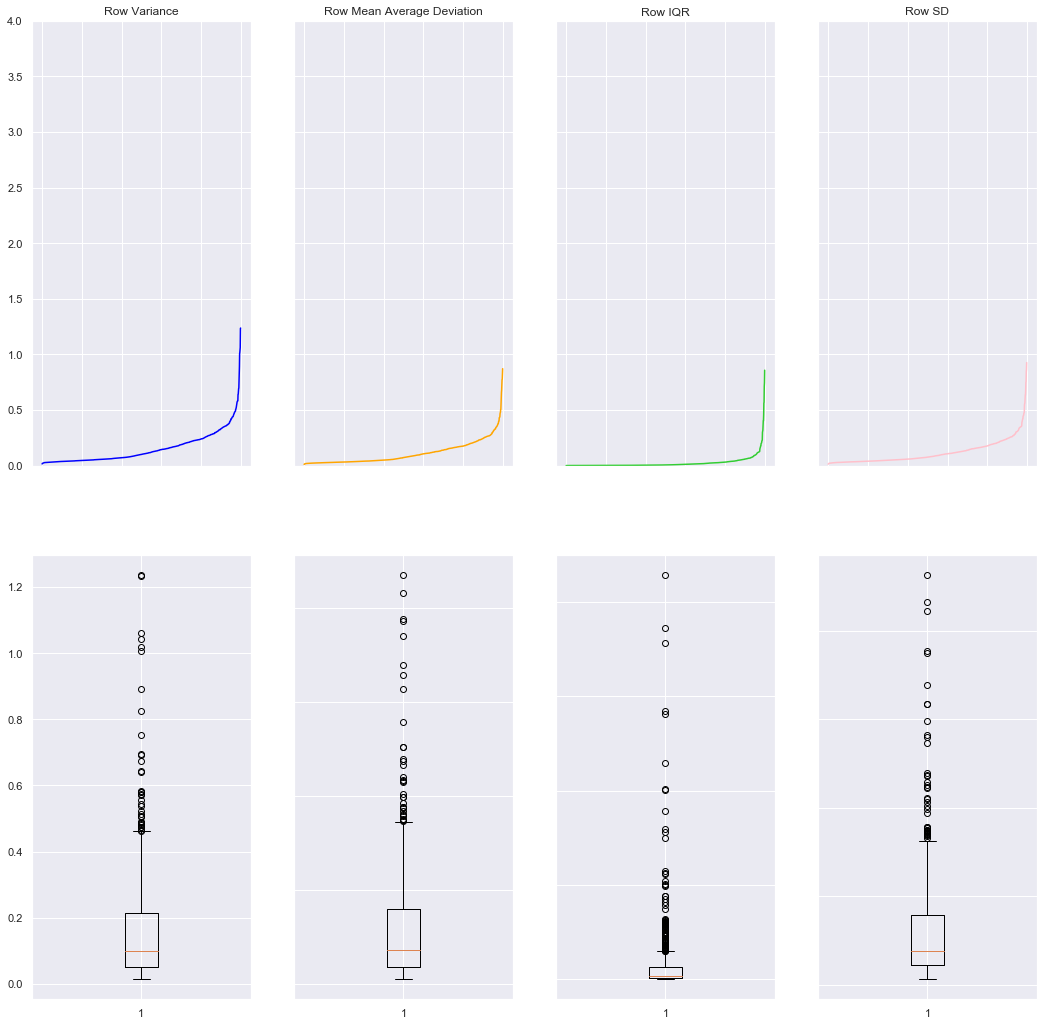

In [17]:
# this will help us visualize how are data could be subsetted.
fig, ((ax1, ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4,figsize=(18,18))

ax1.plot(sorted_row_iqr,color='blue')
ax1.set_ylim([0, 4])
ax1.title.set_text('Row Variance')


ax2.plot(sorted_row_mad, color='orange')
ax2.set_ylim([0, 4])
ax2.title.set_text('Row Mean Average Deviation')

ax3.plot(sorted_row_var, color='#32cd32')
ax3.set_ylim([0, 4])
ax3.title.set_text('Row IQR')

ax4.plot(sorted_row_std, color='Pink')
ax4.set_ylim([0, 4])
ax4.title.set_text('Row SD')


ax5.boxplot(sorted_row_iqr)

ax6.boxplot(sorted_row_mad)

ax7.boxplot(sorted_row_var)

ax8.boxplot(sorted_row_std)

for ax in fig.get_axes():
    ax.label_outer()

#fig.savefig("Row_Statistics.pdf")

In [18]:
from sklearn.preprocessing import StandardScaler as SS
#the following function takes six parameters: the metric list (var,iqr,mad,sd lists), the sorted metric lists,the percentile as 
#an int or float, the dataset features,the string name of the metric ('iqr','var',etc.), and whether data should
# be normalized or not
def subset(metric_list,sorted_metric_list,percentile,datax,metric_string,norm = False):
    #initialize empty list for column indices
    idx_list = []
    # determine what value of the metric is at the cutoff
    threshold = (np.percentile(sorted_metric_list,percentile))
    # go through the metric list and find which columns have metric values greater than or equal to the cutoff
    for i in range(len(metric_list)):
        if metric_list[i] >= threshold:
            idx_list.append(i)
    # create and return a new dataset with only the columns that have metric values 
    #greater than or equal to the cutoff
    dataset = datax.iloc[:,idx_list]
    if norm == True:
        scaler = SS()
        rownames = dataset.index
        dataset = pd.DataFrame(scaler.fit_transform(dataset),columns = dataset.columns)
        dataset.index = rownames

    if norm == False:
        filename = 'data_subset'+'_'+metric_string + '_' + str(percentile) + '_' + 'per.csv'
    else:
        filename = 'data_subset'+ '_'+ 'normalized' +'_'+metric_string + '_' + str(percentile) + '_' + 'per.csv'
    
    return dataset,threshold, filename



In [19]:
# here, for instance, we subset the dataset features using variance and cutoff all values below the 99th percentile
# the metric used was variance, and data was normalized (via Z scoring)
datax_sub,threshold,filename = subset(row_var,sorted_row_var,99,datax,'var',norm=True)


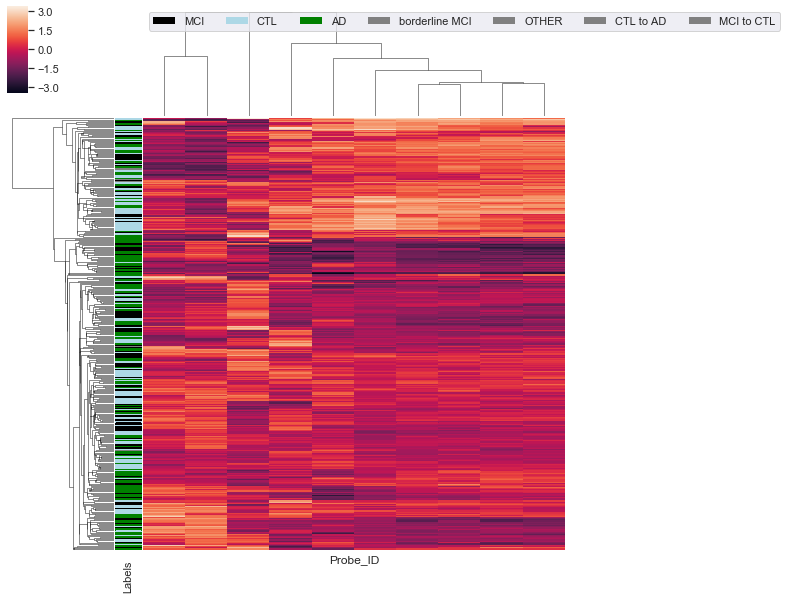

In [20]:
#write to file
#datax_sub.to_csv(filename)
datax_sub.insert(0, "Labels", datay, True)
labels = datax_sub.pop("Labels")
lut = dict(zip(labels.unique(), ['black','#add8e6','green','gray','gray','gray','gray']))
row_colors = labels.map(lut)
GWHM = sns.clustermap(datax_sub,method='centroid',xticklabels=False,yticklabels=0,row_colors=row_colors)


for label in labels.unique():
    GWHM.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
GWHM.ax_col_dendrogram.legend(loc=2, ncol=100)



### Each plot shows the transcipts sorted for their ascending metric scores. A successful subset takes the metric(s) that remove most of the data but have extremely high scores for the remaining.  In this plot, variance is more informative than IQR which is more informative than MAD.

# Classifiers

## Binary Trees

In [35]:
from sklearn.tree import DecisionTreeClassifier
def BinaryTrees(dataset, labels):
    clf = DecisionTreeClassifier(criterion = 'entropy')

    clf = clf.fit(dataset, labels)
    params = {"max_depth": [5,10,15,20], "min_samples_leaf": [5,10,15,20], "max_features": [5,10,15]}

    grid_search = GridSearchCV(clf, params, cv = 5, scoring = 'accuracy')

    grid_search.fit(dataset, labels)

    print(grid_search.best_params_)

    print("Accuracy:", grid_search.best_score_*100)
    

## KNN

In [23]:
#scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_filtered)
print()
print(type(X_scaled))
print(X_scaled.shape)

# make sure the data got scaled correctly
print()
print(X_scaled[0])
print("mean=", X_scaled.mean()) #mean should be 0
print("std=", X_scaled.std())   #std should be 1


<class 'numpy.ndarray'>
(388, 54)

[0.69176284 0.87928653 0.55605977 0.52386614 0.25336585 0.1842341
 0.76861263 0.12675662 0.65160896 0.31414499 0.34072754 0.32444833
 0.16907401 0.9024589  0.34120812 0.82109572 0.53202891 0.13309035
 0.28785064 0.56614745 0.14663342 0.51154284 0.2598357  0.59537792
 0.32562021 0.52672256 0.21108049 0.25106075 0.32477177 0.72694492
 0.51016062 0.88355475 0.13538498 0.233671   0.53637097 0.31868803
 0.26893872 0.54371589 0.42275062 0.24049824 0.28906923 0.42180152
 0.29680571 0.36855793 0.30674501 0.21979556 0.46263291 0.89732619
 0.50706518 0.6514984  0.56563815 0.59281886 0.21968002 0.20168613]
mean= 0.41513561562801526
std= 0.2011097871272961


In [25]:
neigh = KNeighborsClassifier(n_neighbors=5)
params = {'n_neighbors': range(1, 31, 1)}
grid_search = GridSearchCV(neigh, params, cv=10, scoring='accuracy')

grid_search.fit(X_scaled, datay)
print(grid_search.best_params_)
print("Accuracy:", grid_search.best_score_ * 100)

{'n_neighbors': 29}
Accuracy: 47.680412371134025


In [30]:
neigh_best = KNeighborsClassifier(n_neighbors = 29)
predicted_best = cross_val_predict(neigh_best, X_scaled, datay, cv = 10)
print(classification_report(datay, predicted_best))

                precision    recall  f1-score   support

            AD       0.53      0.53      0.53       139
           CTL       0.46      0.57      0.51       134
     CTL to AD       0.00      0.00      0.00         1
           MCI       0.41      0.31      0.36       109
    MCI to CTL       0.00      0.00      0.00         1
         OTHER       0.00      0.00      0.00         1
borderline MCI       0.00      0.00      0.00         3

      accuracy                           0.48       388
     macro avg       0.20      0.20      0.20       388
  weighted avg       0.47      0.48      0.47       388



In [31]:
# Define a pipeline to search for the best combination of 
# PCA dimensions and n_neighbors.

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#crate a scaler
scaler = sk.preprocessing.MinMaxScaler()

#create a PCA
pca = PCA()

#create a KNN classifier
knn = KNeighborsClassifier()

#create a pipeline that does scaling, then PCA, then KNN
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])

#Set up the parameters you want to tune for each of your pipeline steps
#Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': list(range(1, 19)), #find how many principal componenet to keep
    'knn__n_neighbors': list(range(1, 30)),  #find the best value of k
}

# your code goes here:
# pass the pipeline and the parameters into a GridSearchCV with a 5-fold cross validation
grid = GridSearchCV(pipe, param_grid, cv = 5, scoring = "accuracy")

# call fit() on the GridSearchCV and pass in the unscaled data (X_values, Y_values)
grid.fit(X_filtered, datay)

# print out the best_score_ and best_params_ from the GridSearchCV
print("Best Score:", grid.best_score_ * 100)
print("Best Parameters:", grid.best_params_)

Best Score: 48.71134020618557
Best Parameters: {'knn__n_neighbors': 17, 'pca__n_components': 7}


In [32]:
nested_score = cross_val_score(grid, X_filtered, datay, cv = 5)
print("Accuracy:", nested_score.mean() * 100)

Accuracy: 43.5687602354269


## Naive Bayes

In [36]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def NaiveBayes (dataset, labels):
    clf = GaussianNB() # set any params you may want to set

# Run a 5-fold cross validation
    scores = cross_val_score(clf, dataset, labels, cv=10) 
    print("Scores:", scores)                                            

    print("Accuracy:", scores.mean()*100)
    y_pred = cross_val_predict(clf, dataset, labels, cv=10)

    confusion_matrix(labels,y_pred)
    print(classification_report(labels, y_pred))
    

## Neural Nets

In [54]:
scaler = StandardScaler()
mlp = MLPClassifier()
pipeline = Pipeline(steps=[('scaler', scaler),('mlp',mlp)])
param_grid = {'mlp__hidden_layer_sizes':list(range(10,61,10)),'mlp__activation':['logistic', 'tanh', 'relu']}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
y_pred = cross_val_score(grid_search, X_filtered, datay, cv=5)
print(y_pred.mean())

0.4634331634331634


## SVM

In [48]:
scaler = StandardScaler()
svc = SVC()
pipe = Pipeline(steps = [('Scaler', scaler), ('svc', svc)])

scores = cross_val_score(pipe, X_filtered, datay, cv = 5)
print('Accuracy:', scores.mean() * 100)


Accuracy: 52.0651587318254


In [50]:
# for the 'svm' part of the pipeline, tune the 'kernel' hyperparameter
param_grid = {'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_filtered, datay)
print("Best kernel:", grid.best_params_)

Best kernel: {'svc__kernel': 'rbf'}


In [51]:
grid_score = cross_val_score(grid, X_filtered, datay, cv = 5, scoring = 'accuracy')
print('Accuracy:', grid_score.mean() * 100)

Accuracy: 50.4645971312638


In [52]:
params = {'svc__C': range(50, 110, 10), 'svc__kernel': ['rbf']}
grid_search = GridSearchCV(pipe, params, cv = 5)
grid_search_score = cross_val_score(grid_search, X_filtered, datay, cv = 5)
print('Accuracy:', grid_search_score.mean() * 100)

Accuracy: 52.38727572060905


## Ensembles

### AdaBoost

In [63]:
ada = AdaBoostClassifier()
params_ada = {'n_estimators': range(50, 275, 25)}
grid_ada = GridSearchCV(ada, params_ada, cv = 5)
grid_ada.fit(X_filtered, datay)
print('Best params:', grid_ada.best_params_)

scores_ada = cross_val_score(grid_ada, X_filtered, datay, cv = 5)
print('Accuracy:', scores_ada.mean() * 100)

Best params: {'n_estimators': 250}
Accuracy: 44.474984474984474


### Random Forest

In [62]:
rfc = RandomForestClassifier()
params_rfc = {'max_depth': range(35, 56, 1), 'min_samples_leaf': [8, 10, 12], 'max_features': ['sqrt', 'log2']}

grid_rfc = GridSearchCV(rfc, params_rfc, cv = 5)
grid_rfc.fit(X_filtered, datay)
print('Best Params:', grid_rfc.best_params_)

scores_rfc = cross_val_score(grid_rfc, X_filtered, datay, cv = 5, scoring = 'accuracy')
print('Accuracy:', scores_rfc.mean() * 100)

Best Params: {'max_depth': 47, 'max_features': 'sqrt', 'min_samples_leaf': 8}
Accuracy: 45.05380172046839


### Final Ensemble Model

In [61]:
import pickle

# your code goes here
params_final = {'mlp__activation': ['logistic', 'tanh', 'relu'], 'mlp__hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,), (60,)]}
pipe_final = Pipeline(steps = [('Scaler', scaler), ('mlp', mlp)])
grid_final = GridSearchCV(pipe_final, params_final, cv = 5)

# fit GridSearchCV to determine best parameters
grid_final.fit(X_filtered, datay)
print("Best Params:", grid_final.best_params_)
print('Accuracy:', grid_final.best_score_ * 100)

#set this final_model to your final model
final_model = grid_final

filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

Best Params: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (30,)}
Accuracy: 50.0
